# Analyze Steamboat Finisher data

In 2019 the Steamboat 15K race changed from running up and down the Steamboat hills 2 times to 3 times. Want to determine if the change to the course resulted in faster or slower finisher times. 

<a href='https://github.com/mbromberek/race_finisher_analyze'>Github page with source code for getting data and performing analysis</a>

- <a href='#finishtimes'>Comparing finish times for each year by age groups</a>
    - <a href='#finishtimes_byyear_byagegrp_all'>Finisher for all runners by age group for each year</a>
    - <a href='#finishtimes_bycourse_byagegrp_all'>Finisher for all runners by age group for old course versus new course</a>
    - <a href='#finishtimes_byyear_byagegrp_top3'>Top 3 finishers by age group for each year</a>
    - <a href='#finishtimes_bycourse_byagegrp_top3'>Top 3 finishers by age group for old course versus new course</a>
- <a href='#otherfactors'>Other factors that will affect finish times</a>
    - <a href='#weather'>Weather at start of race</a>
    - <a href='#number_finishers'>Number of finishers</a>

## Setup data and functions

In [1]:
# First party libraries
import os
import json

# 3rd Party Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Functions

In [2]:
def seconds_to_str(df, tm_field):
    df_copy = df.copy()
    df_copy['tm_hr'] = (df_copy[tm_field] / 3600).apply(np.floor).astype('int')
    df_copy['tm_min'] = ((df_copy[tm_field]-(df_copy['tm_hr']*3600)) / 60).apply(np.floor).astype('int')
    df_copy['tm_sec'] = (df_copy[tm_field] %60).apply(np.floor).astype('int')
    return df_copy['tm_hr'].astype('str') + ':' + df_copy['tm_min'].astype('str') + ':' + \
        df_copy['tm_sec'].astype('str')


In [3]:
def get_line_graph_plot_for_years(year_list, x, df, y_field):
    line_type = '-'
    plot_lst = []
    for yr in year_list:
        if yr >='2019':
            line_type = '--'
        else:
            line_type = '-'
        plot_lst.extend([x,df[df['year']==yr][y_field], line_type])
    return plot_lst

### Race Finisher Data
- Race data pulled from Athlinks for Steamboat race for years 2016, 2017, 2018, 2019, 2021, 2022, 2023.
- There was only a 4 mile race in 2021


In [4]:
# Filters read in race results to only ones for specified distance
data_dir = 'data'
chart_dir = 'charts'
f_name = 'Steamboat_clean_results.pickle'
race_results_all = pd.read_pickle(os.path.join(data_dir, f_name))
race_dist = '15K'
year_legend_dict = {'15K':['2016','2017','2018','2019','2022','2023'],'4mi':['2016','2017','2018','2019','2021','2022','2023']}
year_list = year_legend_dict[race_dist]
race_results = race_results_all[race_results_all['distance'] == race_dist].copy()

### Weather Data
- Weather manually pulled from Carrott weather for 2016 through 2021
- Weather pulled from Apple WeatherKit for 2022 and 2023

In [5]:
weather_file = 'Steamboat_Weather.json'
weather_dict = {}
with open(os.path.join(data_dir, weather_file)) as json_file:
    weather_dict = json.load(json_file)


In [6]:
print(race_results.info())

<class 'pandas.core.frame.DataFrame'>
Index: 3302 entries, 0 to 3301
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   gender        3302 non-null   object
 1   age           3302 non-null   int64 
 2   time          3302 non-null   object
 3   distance      3302 non-null   object
 4   year          3302 non-null   object
 5   time_seconds  3302 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 180.6+ KB
None


In [7]:
race_results.groupby(['year']).agg(finisher_count=('age', 'count'))

,finisher_count
year,
2016,821
2017,665
2018,655
2019,545
2022,293
2023,323


In [8]:
# Can see number of runners for 15K went down a lot after 2019
race_results.groupby(['year','gender']).agg(finisher_count=('age', 'count'))

finisher_count
year gender                
2016 F                  363
     M                  458
2017 F                  295
     M                  370
2018 F                  289
     M                  366
2019 F                  227
     M                  318
2022 F                  128
     M                  165
2023 F                  115
     M                  208

### Use Age Groups of every 5 years
- Calculate average and median finish times for age groups

In [9]:
age_group_years = 5
if age_group_years == 5:
    conditions = [
        race_results['age'].lt(20),
        race_results['age'].ge(20) & race_results['age'].lt(25),
        race_results['age'].ge(25) & race_results['age'].lt(30),
        race_results['age'].ge(30) & race_results['age'].lt(35),
        race_results['age'].ge(35) & race_results['age'].lt(40),
        race_results['age'].ge(40) & race_results['age'].lt(45),
        race_results['age'].ge(45) & race_results['age'].lt(50),
        race_results['age'].ge(50) & race_results['age'].lt(55),
        race_results['age'].ge(55) & race_results['age'].lt(60),
        race_results['age'].ge(60) & race_results['age'].lt(65),
        race_results['age'].ge(65) & race_results['age'].lt(70),
        race_results['age'].ge(70)
    ]
    choices = ['0 to 19','20 to 24','25 to 29','30 to 34','35 to 39','40 to 44','45 to 49', \
               '50 to 54','55 to 59','60 to 64','65 to 69','70 Over']
else:
    conditions = [
        race_results['age'].lt(20),
        race_results['age'].ge(20) & race_results['age'].lt(30),
        race_results['age'].ge(30) & race_results['age'].lt(40),
        race_results['age'].ge(40) & race_results['age'].lt(50),
        race_results['age'].ge(50) & race_results['age'].lt(60),
        race_results['age'].ge(60) & race_results['age'].lt(70),
        race_results['age'].ge(70)
    ]
    choices = ['0 to 19','20 to 29','30 to 39','40 to 49','50 to 59','60 to 69','70 Over']
race_results['age_group'] = np.select(conditions, choices, default=0)


In [10]:
conditions = [
    race_results['year'].isin(['2016','2017','2018']),
    race_results['year'].isin(['2019','2021','2022','2023'])
]
choices = ['2 loops','3 loops']
race_results['race_course'] = np.select(conditions, choices, default=0)

In [11]:
# The unstack, stack is used to have a record for all age groups for all years and genders
age_grp_det = race_results.groupby(['year','gender','age_group'])\
    .agg(finisher_count=('age', 'count')
         , avg_time_s = ('time_seconds','mean')
         , fastest_time_s = ('time_seconds','min')
         , slowest_time_s = ('time_seconds','max')
         , median_time_s = ('time_seconds','median')
        ).unstack(fill_value=0).stack().reset_index()

age_grp_det['avg_time_string'] = seconds_to_str(age_grp_det, 'avg_time_s')
age_grp_det['avg_time_minute'] = age_grp_det['avg_time_s'] /60
age_grp_det['median_time_string'] = seconds_to_str(age_grp_det, 'median_time_s')
age_grp_det['median_time_minute'] = age_grp_det['median_time_s'] /60

# age_grp_det.info()

In [12]:
# The unstack, stack is used to have a record for all age groups for all years and genders
course_loops = race_results.groupby(['race_course','gender','age_group'])\
    .agg(finisher_count=('age', 'count')
         , avg_time_s = ('time_seconds','mean')
         , fastest_time_s = ('time_seconds','min')
         , slowest_time_s = ('time_seconds','max')
         , median_time_s = ('time_seconds','median')
        ).unstack(fill_value=0).stack().reset_index()

course_loops['avg_time_string'] = seconds_to_str(course_loops, 'avg_time_s')
course_loops['avg_time_minute'] = course_loops['avg_time_s'] /60
course_loops['median_time_string'] = seconds_to_str(course_loops, 'median_time_s')
course_loops['median_time_minute'] = course_loops['median_time_s'] /60

# course_loops.info()


In [13]:
age_grp_men = age_grp_det[age_grp_det['gender'] =='M'].reset_index().\
    drop(columns=['index','gender'])
age_grp_women = age_grp_det[age_grp_det['gender'] =='F'].reset_index().\
    drop(columns=['index','gender'])


<a id='finishtimes'></a>
# Comparing Finish Times for each year by age groups
- Median finishing time by age groups for each year
- Median finishing time by age groups for 3 years of 2 hill loop course and 3 years of 3 hill loop course
- Median finishing time for top 3 of each age groups for each year
- Median finishing time for top 3 of each age groups for 3 years of 2 hill loop course and 3 years of 3 hill loop course

In [14]:
age_grp_det[(age_grp_det['year']=='2018') & (age_grp_det['gender'] == 'M')]\
    [['year','gender','age_group','finisher_count','avg_time_string','avg_time_minute',\
      'median_time_string','median_time_minute'
     ]]

,year,gender,age_group,finisher_count,avg_time_string,avg_time_minute,median_time_string,median_time_minute
60,2018,M,0 to 19,17,1:9:1,69.016667,1:9:44,69.733333
61,2018,M,20 to 24,24,1:17:43,77.722222,1:13:39,73.658333
62,2018,M,25 to 29,38,1:26:14,86.235526,1:26:31,86.516667
63,2018,M,30 to 34,52,1:29:31,89.524038,1:23:16,83.266667
64,2018,M,35 to 39,66,1:26:23,86.399242,1:24:27,84.458333
65,2018,M,40 to 44,35,1:25:48,85.804286,1:22:32,82.533333
66,2018,M,45 to 49,41,1:27:46,87.769106,1:27:22,87.366667
67,2018,M,50 to 54,35,1:30:38,90.645714,1:28:32,88.533333
68,2018,M,55 to 59,26,1:36:57,96.956410,1:31:49,91.825000
69,2018,M,60 to 64,20,1:35:51,95.860000,1:36:59,96.991667


In [15]:
age_grp_det[(age_grp_det['year']=='2023') & (age_grp_det['gender'] == 'M')]\
    [['year','gender','age_group','finisher_count','avg_time_minute','median_time_minute']]

,year,gender,age_group,finisher_count,avg_time_minute,median_time_minute
132,2023,M,0 to 19,10,64.733333,56.616667
133,2023,M,20 to 24,22,58.427273,52.466667
134,2023,M,25 to 29,18,82.766667,85.908333
135,2023,M,30 to 34,31,81.568817,84.483333
136,2023,M,35 to 39,32,80.820833,79.766667
137,2023,M,40 to 44,28,85.912500,81.641667
138,2023,M,45 to 49,26,84.147436,83.550000
139,2023,M,50 to 54,17,83.108824,82.033333
140,2023,M,55 to 59,8,86.922917,83.375000
141,2023,M,60 to 64,10,83.978333,83.791667


<a id='finishtimes_byyear_byagegrp_all'></a>
## Comparing median finish times by age group for each race
- dashed lines are for 3 loop course

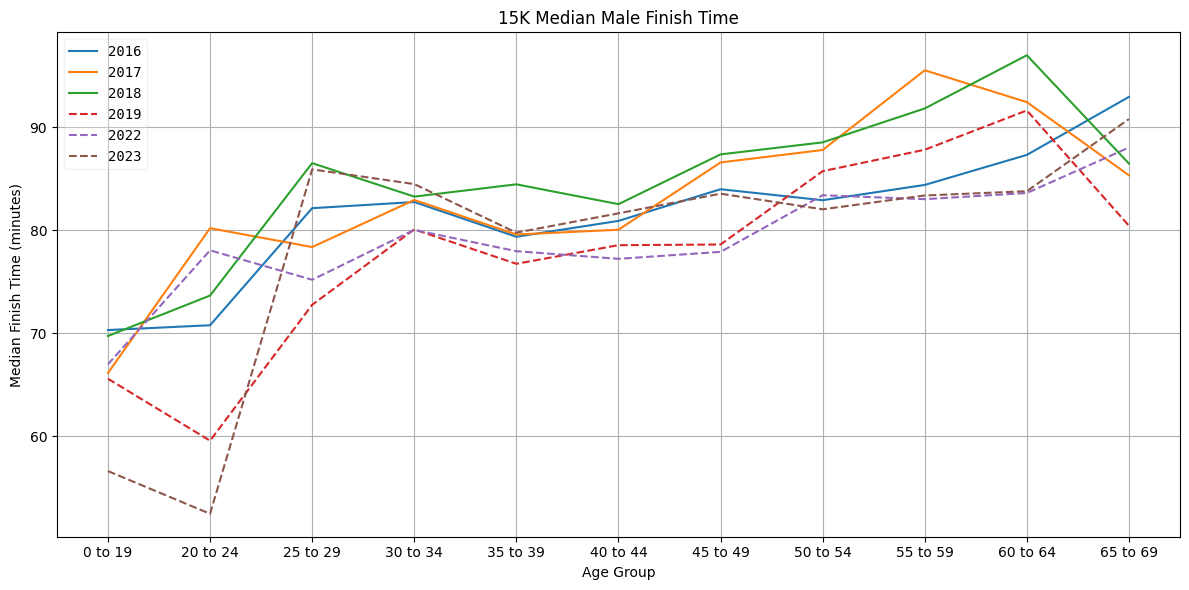

In [16]:
# Remove 70 Over group to make the fastest and slowest time range smaller
gender_grp = age_grp_men[age_grp_men['age_group'] != '70 Over'].copy()
graph_field = 'median_time_minute'

x = gender_grp['age_group'].unique()
plots = plt.plot(*get_line_graph_plot_for_years(year_list, x, gender_grp, graph_field))
plt.legend(plots, (year_list), loc='best', 
           framealpha=0.25, prop={'size':'medium', 'family':'monospace'})
plt.gcf().set_size_inches(12,6)
plt.title(race_dist+' Median Male Finish Time')
plt.xlabel('Age Group')
plt.ylabel('Median Finish Time (minutes)')
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(chart_dir, race_dist+'_Median_male_finisher_times_5yr_age_goups.png'), dpi=200)

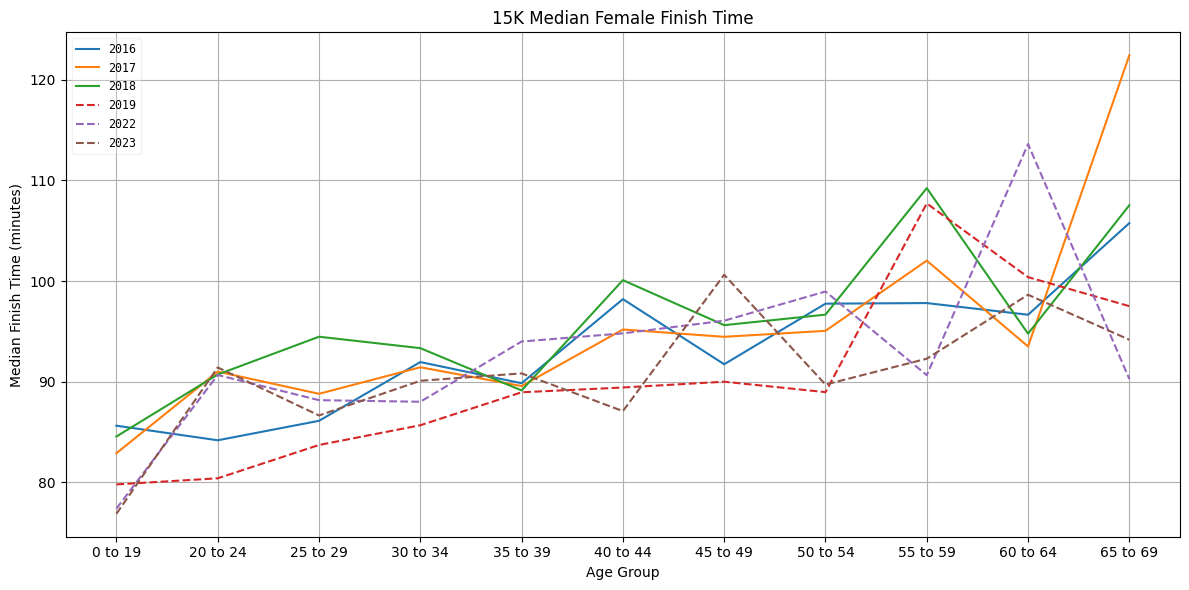

In [17]:
# Remove 70 Over group to make the fastest and slowest time range smaller
gender_grp = age_grp_women[age_grp_women['age_group'] != '70 Over']
graph_field = 'median_time_minute'

x = gender_grp['age_group'].unique()
plots = plt.plot(*get_line_graph_plot_for_years(year_list, x, gender_grp, graph_field))
plt.legend(plots, (year_list), loc='best', 
           framealpha=0.25, prop={'size':'small', 'family':'monospace'})
plt.gcf().set_size_inches(12,6)
plt.title(race_dist+' Median Female Finish Time')
plt.xlabel('Age Group')
plt.ylabel('Median Finish Time (minutes)')
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(chart_dir, race_dist+'_Median_female_finisher_times_5yr_age_goups.png'), dpi=200)

<a id='finishtimes_bycourse_byagegrp_all'></a>
## Finish times for 2 versus 3 times up Steamboat Hill
Combine finishing times for 2016 through 2018 into “2 loop course” and 2019, 2022, and 2023 into “3 loop course” and get the median for those groups.

We can clearly see that the mens finishing times are always faster with the 3 loop course and the 3 loop course is usually faster for women. 

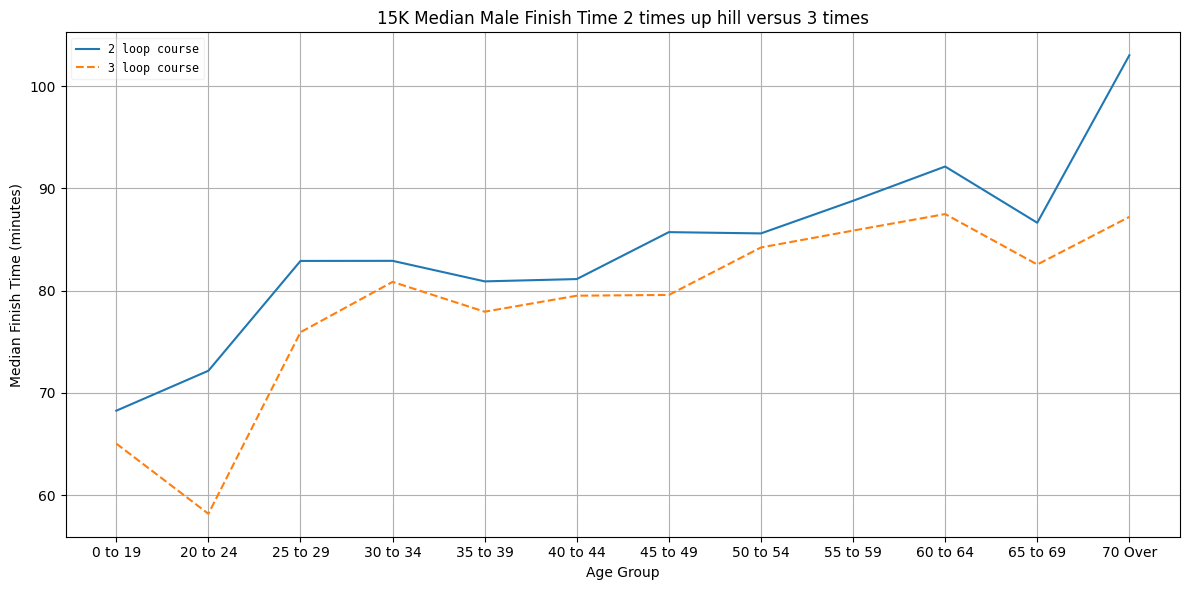

In [19]:
gender_grp = course_loops[course_loops['gender']=='M'].copy()
x = gender_grp['age_group'].unique()
graph_field = 'median_time_minute'
plots = plt.plot(x,gender_grp[gender_grp['race_course']=='2 loops'][graph_field], '-', 
                 x,gender_grp[gender_grp['race_course']=='3 loops'][graph_field], '--'
                )
plt.legend(plots, ('2 loop course','3 loop course'), loc='best', 
           framealpha=0.25, prop={'size':'small', 'family':'monospace'})
plt.gcf().set_size_inches(12,6)
plt.title(race_dist+' Median Male Finish Time 2 times up hill versus 3 times')
plt.xlabel('Age Group')
plt.ylabel('Median Finish Time (minutes)')
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(chart_dir, race_dist+'_Median_male_finisher_times_5yr_age_goups_2_vs_3_loops.png'), dpi=200)

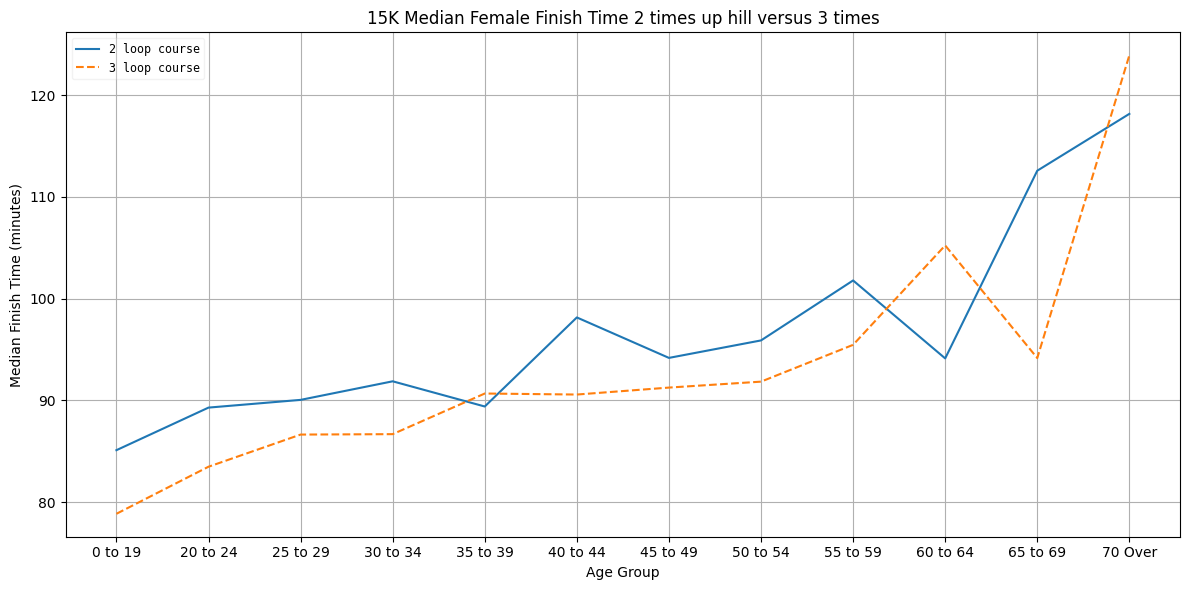

In [20]:
gender_grp = course_loops[course_loops['gender']=='F'].copy()
x = gender_grp['age_group'].unique()
graph_field = 'median_time_minute'
plots = plt.plot(x,gender_grp[gender_grp['race_course']=='2 loops'][graph_field], '-', 
                 x,gender_grp[gender_grp['race_course']=='3 loops'][graph_field], '--'
                )
plt.legend(plots, ('2 loop course','3 loop course'), loc='best', 
           framealpha=0.25, prop={'size':'small', 'family':'monospace'})
plt.gcf().set_size_inches(12,6)
plt.title(race_dist+' Median Female Finish Time 2 times up hill versus 3 times')
plt.xlabel('Age Group')
plt.ylabel('Median Finish Time (minutes)')
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(chart_dir, race_dist+'_Median_female_finisher_times_5yr_age_goups_2_vs_3_loops.png'), dpi=200)

<a id='finishtimes_byyear_byagegrp_top3'></a>

<a id='finishtimes_byyear_byagegrp_top3'></a>
## Finish times of top three by age group
Using the top 3 finishers for each age group the median finish time for men and women is much closer indicating the top 3 finisher for each age group was not significantly impacted by the course change. 

In [21]:
race_results['age_grp_place'] = race_results.groupby(['year','gender','age_group']).cumcount()
age_grp_top3 = race_results[race_results['age_grp_place'] <3]

In [22]:
# The unstack, stack is used to have a record for all age groups for all years and genders
age_grp_det_top3 = age_grp_top3.groupby(['year','gender','age_group'])\
    .agg(finisher_count=('age', 'count')
         , avg_time_s = ('time_seconds','mean')
         , fastest_time_s = ('time_seconds','min')
         , slowest_time_s = ('time_seconds','max')
         , median_time_s = ('time_seconds','median')
        ).unstack(fill_value=0).stack().reset_index()

age_grp_det_top3['avg_time_string'] = seconds_to_str(age_grp_det_top3, 'avg_time_s')
age_grp_det_top3['avg_time_minute'] = age_grp_det_top3['avg_time_s'] /60
age_grp_det_top3['median_time_string'] = seconds_to_str(age_grp_det_top3, 'median_time_s')
age_grp_det_top3['median_time_minute'] = age_grp_det_top3['median_time_s'] /60

# age_grp_det_top3.info()

In [23]:
# The unstack, stack is used to have a record for all age groups for all years and genders
course_loops_top3 = age_grp_top3.groupby(['race_course','gender','age_group'])\
    .agg(finisher_count=('age', 'count')
         , avg_time_s = ('time_seconds','mean')
         , fastest_time_s = ('time_seconds','min')
         , slowest_time_s = ('time_seconds','max')
         , median_time_s = ('time_seconds','median')
        ).unstack(fill_value=0).stack().reset_index()

course_loops_top3['avg_time_string'] = seconds_to_str(course_loops_top3, 'avg_time_s')
course_loops_top3['avg_time_minute'] = course_loops_top3['avg_time_s'] /60
course_loops_top3['median_time_string'] = seconds_to_str(course_loops_top3, 'median_time_s')
course_loops_top3['median_time_minute'] = course_loops_top3['median_time_s'] /60

# course_loops_top3.info()


In [24]:
age_grp_det_top3.head(20)

,year,gender,age_group,finisher_count,avg_time_s,fastest_time_s,slowest_time_s,median_time_s,avg_time_string,avg_time_minute,median_time_string,median_time_minute
0,2016,F,0 to 19,3,3947.000000,3654,4231,3956.0,1:5:47,65.783333,1:5:56,65.933333
1,2016,F,20 to 24,3,4010.333333,3985,4026,4020.0,1:6:50,66.838889,1:7:0,67.000000
2,2016,F,25 to 29,3,4203.333333,4131,4292,4187.0,1:10:3,70.055556,1:9:47,69.783333
3,2016,F,30 to 34,3,3797.666667,3537,4058,3798.0,1:3:17,63.294444,1:3:18,63.300000
4,2016,F,35 to 39,3,4256.666667,4220,4310,4240.0,1:10:56,70.944444,1:10:40,70.666667
5,2016,F,40 to 44,3,4051.000000,3969,4158,4026.0,1:7:31,67.516667,1:7:6,67.100000
6,2016,F,45 to 49,3,4699.000000,4587,4780,4730.0,1:18:19,78.316667,1:18:50,78.833333
7,2016,F,50 to 54,3,4591.666667,4328,4755,4692.0,1:16:31,76.527778,1:18:12,78.200000
8,2016,F,55 to 59,3,4975.000000,4858,5134,4933.0,1:22:55,82.916667,1:22:13,82.216667
9,2016,F,60 to 64,3,4863.666667,4814,4904,4873.0,1:21:3,81.061111,1:21:13,81.216667


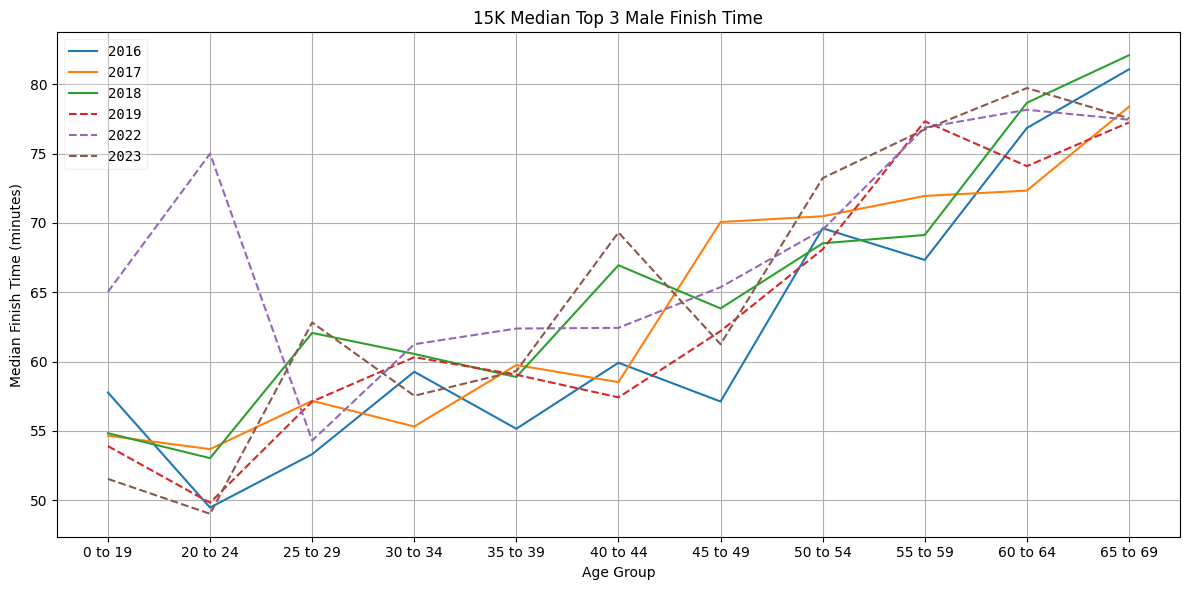

In [25]:
# Remove 70 Over group to make the fastest and slowest time range smaller
gender_grp = age_grp_det_top3[(age_grp_det_top3['gender'] == 'M') & (age_grp_det_top3['age_group'] != '70 Over')].copy()
# time_field = 'avg_time_minute'
time_field = 'median_time_minute'

x = gender_grp['age_group'].unique()
plots = plt.plot(*get_line_graph_plot_for_years(year_list, x, gender_grp, time_field))
plt.legend(plots, (year_list), loc='best', 
           framealpha=0.25, prop={'size':'medium', 'family':'monospace'})
plt.gcf().set_size_inches(12,6)
plt.title(race_dist+' Median Top 3 Male Finish Time')
plt.xlabel('Age Group')
plt.ylabel('Median Finish Time (minutes)')
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(chart_dir, race_dist+'_Median_male_finisher_times_5yr_age_goups_top3.png'), dpi=200)

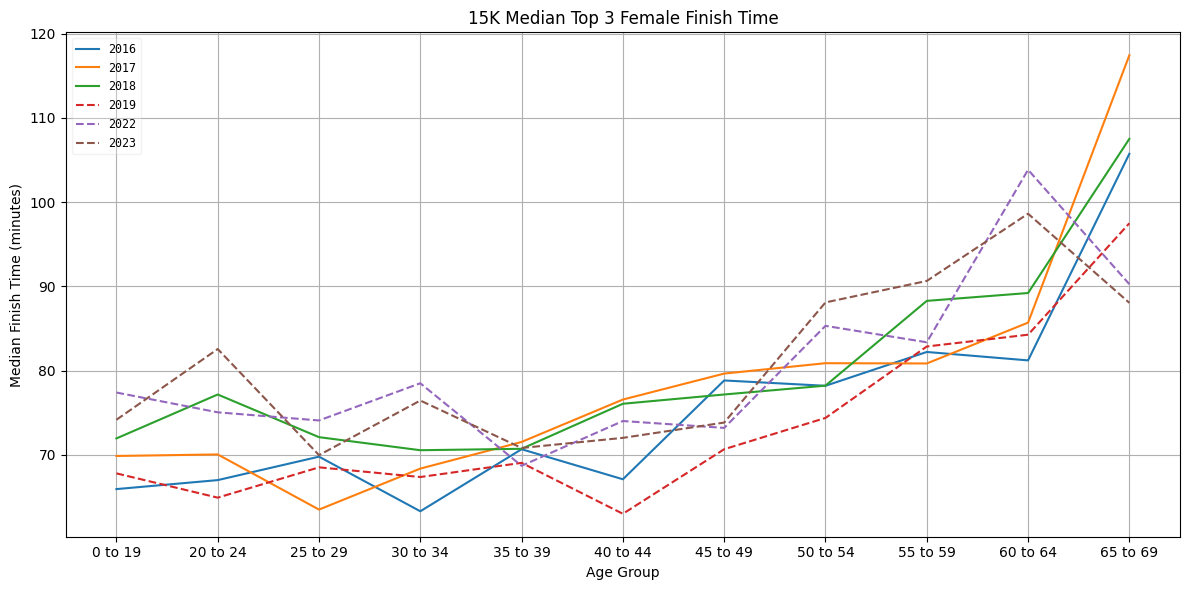

In [26]:
# Remove 70 Over group to make the fastest and slowest time range smaller
gender_grp = age_grp_det_top3[(age_grp_det_top3['gender'] == 'F') & (age_grp_det_top3['age_group'] != '70 Over')].copy()
x = gender_grp['age_group'].unique()
graph_field = 'median_time_minute'

plots = plt.plot(*get_line_graph_plot_for_years(year_list, x, gender_grp, graph_field))
plt.legend(plots, (year_list), loc='best', 
           framealpha=0.25, prop={'size':'small', 'family':'monospace'})
plt.gcf().set_size_inches(12,6)
plt.title(race_dist+' Median Top 3 Female Finish Time')
plt.xlabel('Age Group')
plt.ylabel('Median Finish Time (minutes)')
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(chart_dir, race_dist+'_Median_female_finisher_times_5yr_age_goups_top3.png'), dpi=200)

<a id='finishtimes_bycourse_byagegrp_top3'></a>
## Top three by age group for 2 versus 3 times up Steamboat Hill

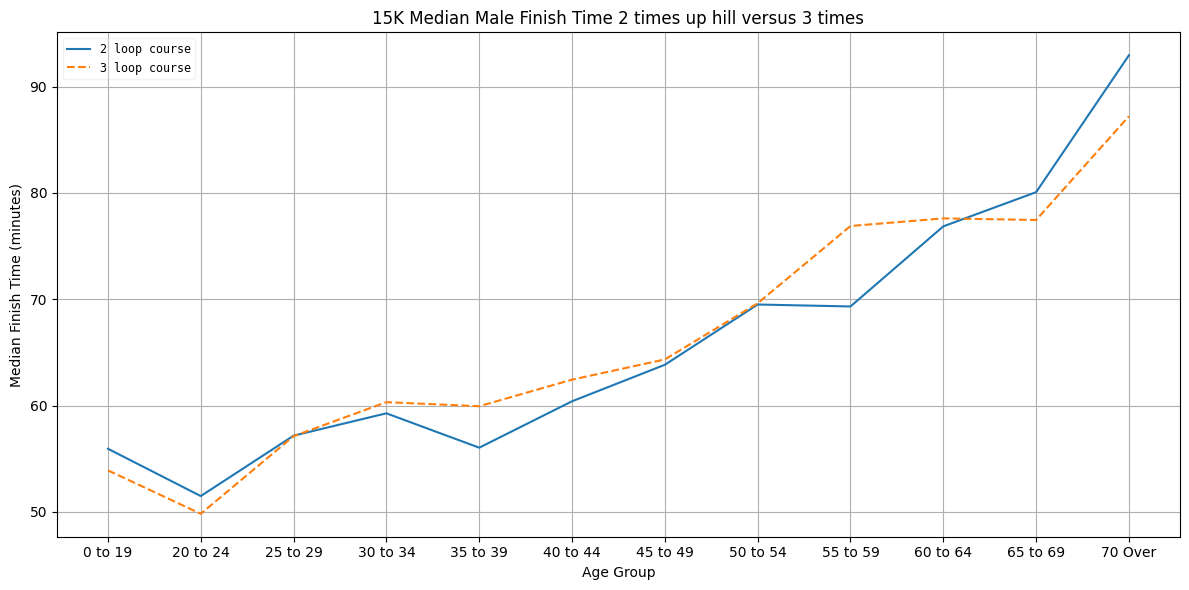

In [27]:
gender_grp = course_loops_top3[course_loops_top3['gender']=='M'].copy()
x = gender_grp['age_group'].unique()
# time_field = 'avg_time_minute'
time_field = 'median_time_minute'
plots = plt.plot(x,gender_grp[gender_grp['race_course']=='2 loops'][time_field], '-', 
                 x,gender_grp[gender_grp['race_course']=='3 loops'][time_field], '--'
                )
plt.legend(plots, ('2 loop course','3 loop course'), loc='best', 
           framealpha=0.25, prop={'size':'small', 'family':'monospace'})
plt.gcf().set_size_inches(12,6)
plt.title(race_dist+' Median Male Finish Time 2 times up hill versus 3 times')
plt.xlabel('Age Group')
plt.ylabel('Median Finish Time (minutes)')
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(chart_dir, race_dist+'_Median_male_finisher_times_5yr_age_goups_2_vs_3_loops_top3.png'), dpi=200)

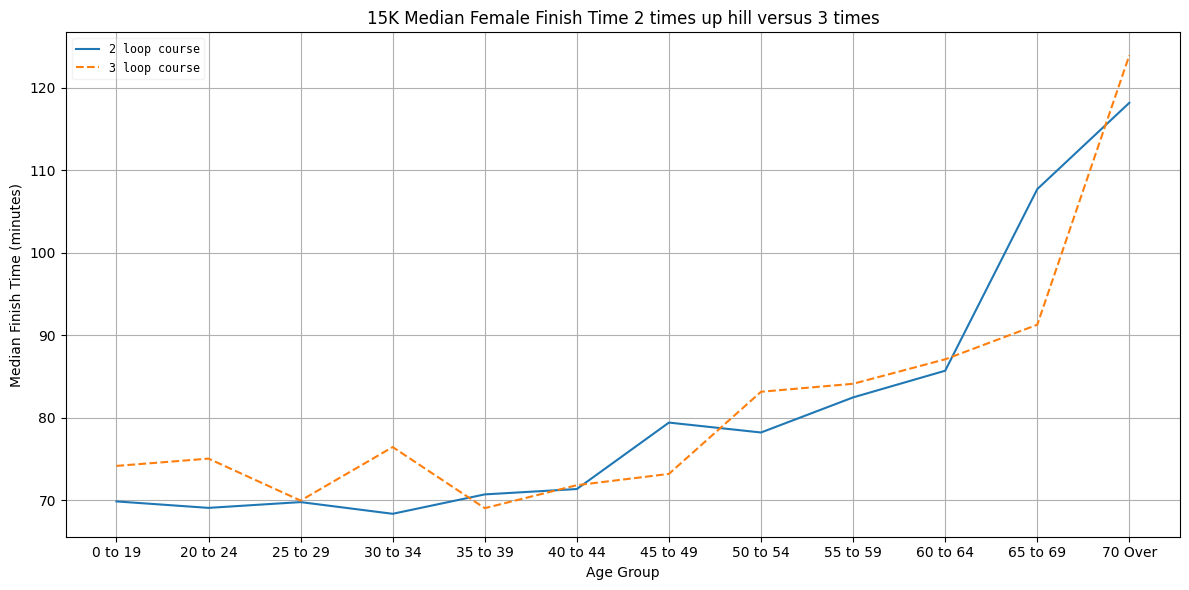

In [28]:
gender_grp = course_loops_top3[course_loops_top3['gender']=='F'].copy()
x = gender_grp['age_group'].unique()
# time_field = 'avg_time_minute'
time_field = 'median_time_minute'
plots = plt.plot(x,gender_grp[gender_grp['race_course']=='2 loops'][time_field], '-', 
                 x,gender_grp[gender_grp['race_course']=='3 loops'][time_field], '--'
                )
plt.legend(plots, ('2 loop course','3 loop course'), loc='best', 
           framealpha=0.25, prop={'size':'small', 'family':'monospace'})
plt.gcf().set_size_inches(12,6)
plt.title(race_dist+' Median Female Finish Time 2 times up hill versus 3 times')
plt.xlabel('Age Group')
plt.ylabel('Median Finish Time (minutes)')
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(chart_dir, race_dist+'_Median_female_finisher_times_5yr_age_goups_2_vs_3_loops_top3.png'), dpi=200)

<a id='otherfactors'></a>
# Other factors that will affect finisher times
- The starting temperature for the race was better for each of the years that had the 3 loops of the Steamboat Hill when compared to the 2 loop years. The improved weather could be causing the improved performance instead of the change to the course. 
- The number of finishers for the 15K are lower with the 3 loop course compared to the 2 loop course. So could have less slower runners resulting in the different median finishing times. 

<a id='weather'></a>
## Weather at start of race

In [29]:
df_weather = pd.DataFrame.from_dict(weather_dict, orient='index')
df_weather['date'] = pd.to_datetime(df_weather['date'])

In [30]:
print(df_weather.rename(columns={\
    'temperature':'Temperature','temperatureApparent':'Feels Like','temperatureDewPoint':'Dew Point','cloudCover':'Cloud Cover'\
    })\
    [['Temperature','Feels Like','Dew Point','Cloud Cover']])

      Temperature  Feels Like  Dew Point  Cloud Cover
2016        68.00       67.00      57.00        22.00
2017        72.00       78.00      69.00        51.00
2018        75.00       80.00      70.00         1.00
2019        64.00       63.00      60.00        85.00
2021        73.00       76.00      71.00        28.00
2022        65.05       64.40      53.08         0.00
2023        57.36       56.79      52.95         0.02


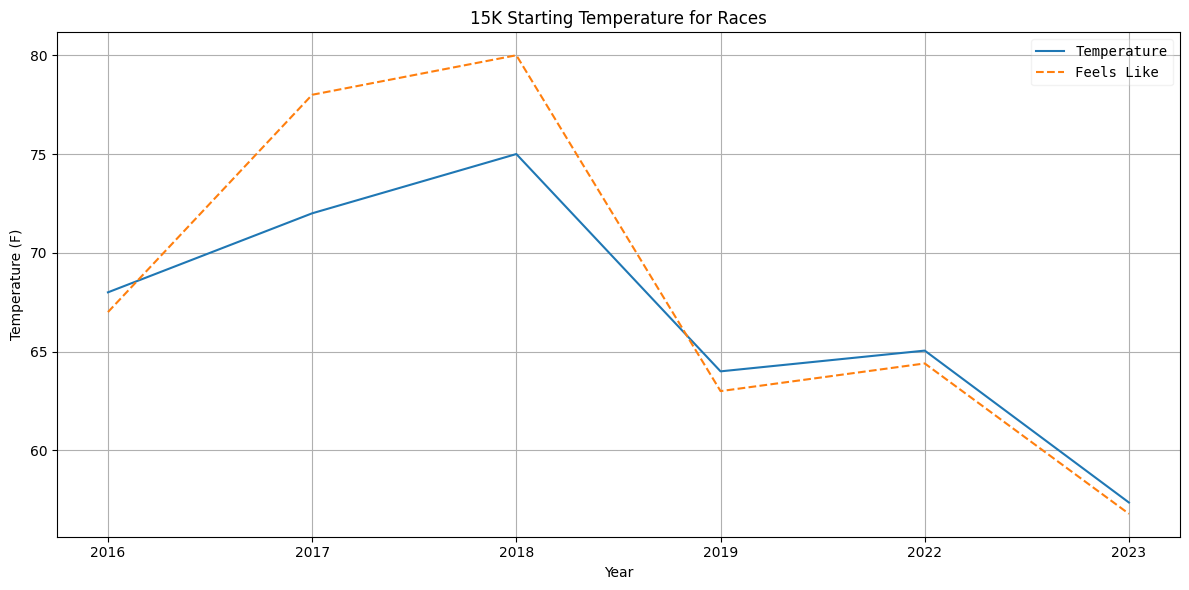

In [31]:
df = df_weather[df_weather.index.isin(year_list)]
x = df.index

plots = plt.plot(x,df['temperature'], '-',
                 x,df['temperatureApparent'], '--',
                )

plt.legend(plots, (['Temperature','Feels Like']), loc='best', 
           framealpha=0.25, prop={'size':'medium', 'family':'monospace'})
plt.gcf().set_size_inches(12,6)
plt.title(race_dist+' Starting Temperature for Races')
plt.xlabel('Year')
plt.ylabel('Temperature (F)')
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(chart_dir, race_dist+'_Starting_Weather.png'), dpi=200)

<a id='number_finishers'></a>
## Number of Finishers

### Number of finishers in age groups

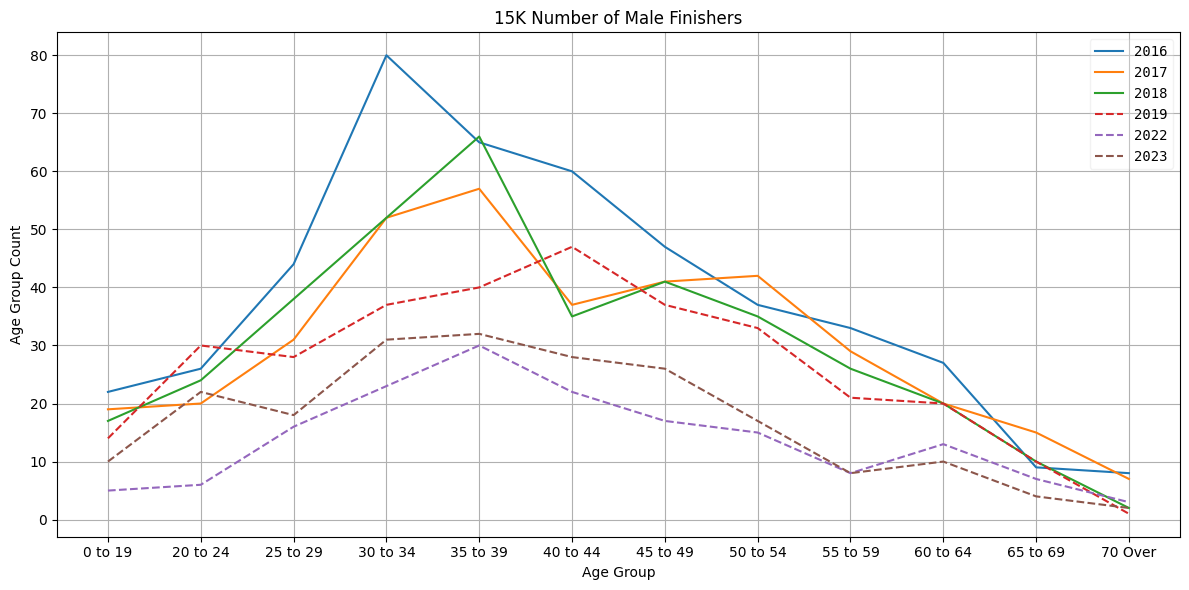

In [32]:
x = age_grp_men['age_group'].unique()
graph_field = 'finisher_count'

plot_lines = get_line_graph_plot_for_years(year_list, x, age_grp_men, graph_field)
plots = plt.plot(*plot_lines)

plt.legend(plots, (year_list), loc='best', 
           framealpha=0.25, prop={'size':'medium', 'family':'monospace'})
plt.gcf().set_size_inches(12,6)
plt.title(race_dist+' Number of Male Finishers')
plt.xlabel('Age Group')
plt.ylabel('Age Group Count')
plt.grid(True)
plt.tight_layout()
# plt.savefig(os.path.join(data_dir, 'Count_male_finishers_5yr_age_goups.svg'))
plt.savefig(os.path.join(chart_dir, race_dist+'_Count_male_finishers_5yr_age_goups.png'), dpi=200)

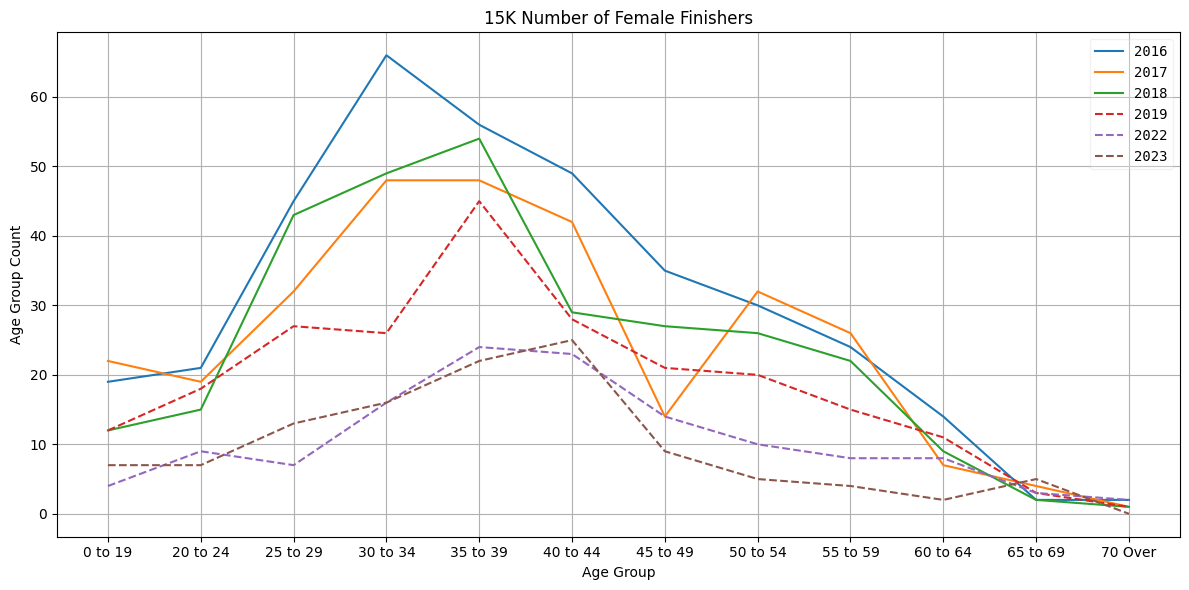

In [33]:
x = age_grp_women['age_group'].unique()
graph_field = 'finisher_count'

plot_lines = get_line_graph_plot_for_years(year_list, x, age_grp_women, graph_field)
plots = plt.plot(*plot_lines)

plt.legend(plots, (year_list), loc='best', 
           framealpha=0.25, prop={'size':'medium', 'family':'monospace'})
plt.gcf().set_size_inches(12,6)
plt.title(race_dist+' Number of Female Finishers')
plt.xlabel('Age Group')
plt.ylabel('Age Group Count')
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(chart_dir, race_dist+'_Count_female_finishers_5yr_age_goups.png'), dpi=200)

### Total number of male and female finishers by year

In [34]:
gender_ct = race_results.groupby(['year','gender']).agg(finisher_count=('age', 'count'))\
    .unstack(fill_value=0).stack().reset_index()

In [35]:
print(gender_ct)

    year gender  finisher_count
0   2016      F             363
1   2016      M             458
2   2017      F             295
3   2017      M             370
4   2018      F             289
5   2018      M             366
6   2019      F             227
7   2019      M             318
8   2022      F             128
9   2022      M             165
10  2023      F             115
11  2023      M             208


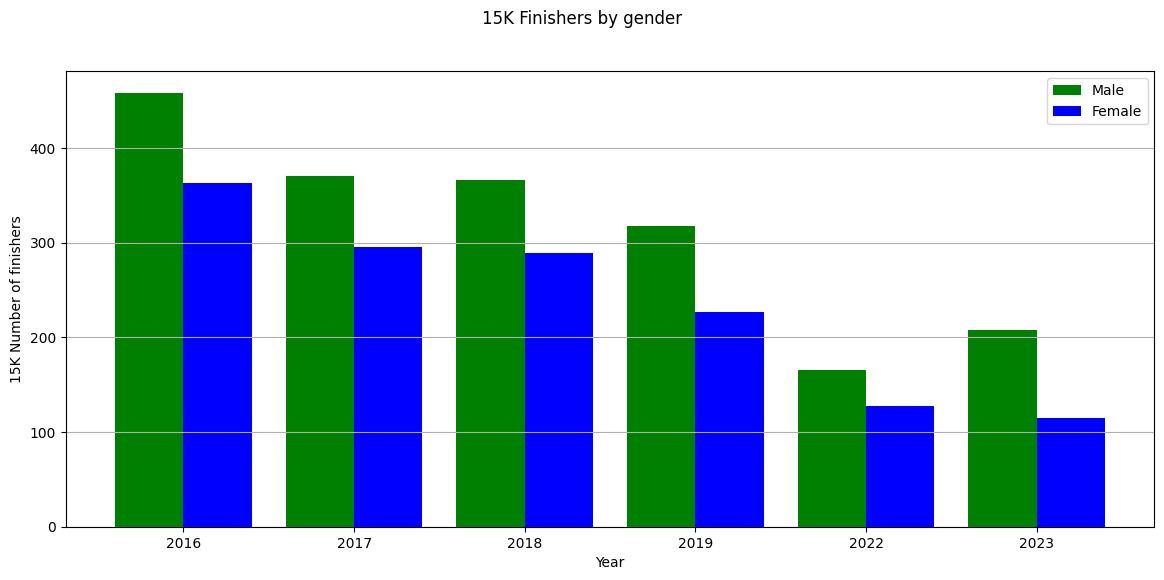

In [36]:
labels = gender_ct['year'].unique()
men_ct_data = gender_ct[gender_ct['gender']=='M']['finisher_count']
women_ct_data = gender_ct[gender_ct['gender']=='F']['finisher_count']

fig, ax = plt.subplots(figsize=(12,6))
bar_width=0.4
xlocs = np.arange(len(labels))

ax.bar(xlocs -bar_width*0.5, men_ct_data, bar_width, color='green', label='Male')
ax.bar(xlocs +bar_width*0.5, women_ct_data, bar_width, color='blue', label='Female')

ax.set_yticks(range(0, gender_ct['finisher_count'].max()+10, 100))
    
ax.set_xticks(ticks=range(len(men_ct_data)))
ax.set_xticklabels(labels)
ax.yaxis.grid(True)
ax.legend(loc='best')
ax.set_ylabel(race_dist+' Number of finishers')
ax.set_xlabel('Year')
fig.suptitle(race_dist+' Finishers by gender')
fig.tight_layout(pad=2)
fig.savefig(os.path.join(chart_dir, race_dist+'_Finisher_count_by_gender.png'), dpi=200)
